In [1]:
import random
import csv
import paramiko
from multiprocessing import Pool

# Function to generate a bandwidth matrix for a given number of nodes
def generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=600):
    # Create a matrix with zeros or very high values on the diagonal
    bandwidth_matrix = [[0 if i == j else random.randint(min_bandwidth, max_bandwidth)
                         for j in range(num_nodes)] for i in range(num_nodes)]
    return bandwidth_matrix

# Generate bandwidth matrix for 9 nodes
num_nodes = 9
bandwidth_matrix = generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=800)  # Bandwidth in Mbps

# Save the bandwidth matrix to a CSV file
with open('bandwidth_matrix.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(bandwidth_matrix)

# Print matrix to verify
for row in bandwidth_matrix:
    print(row)

# List of node names to map to bandwidth matrix indices
node_names = [
    'k8s-worker-1', 'k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4',
    'k8s-worker-5', 'k8s-worker-6', 'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9'
]

# Function to apply bandwidth settings between nodes
def apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details, node_names):
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()

    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)

        # Clear existing rules and set root qdisc
        client.exec_command(f"sudo tc qdisc del dev {interface} root")
        client.exec_command(f"sudo tc qdisc add dev {interface} root handle 1: htb default 1")
        
        print(f'Bandwidth cleared for {source_node_name}')

        # Get the index of the source node
        source_index = node_names.index(source_node_name)

        for dst_node, details in node_details.items():
            if dst_node == source_node_name:
                continue

            dst_node_ip = details['ip']
            dst_index = node_names.index(dst_node)  # Get the index of the destination node
            bandwidth = bandwidth_matrix[source_index][dst_index]  # Access bandwidth matrix using indices

            print(f'Setting bandwidth between {source_node_name} and {dst_node}: {bandwidth} Mbps')
            client.exec_command(f"sudo tc class add dev {interface} parent 1: classid 1:1 htb rate {bandwidth}mbit")
            client.exec_command(f"sudo tc filter add dev {interface} protocol ip parent 1:0 prio 1 u32 match ip dst {dst_node_ip} flowid 1:1")
            print(f'Bandwidth set between {source_node_name} and {dst_node}: {bandwidth} Mbps')

    except Exception as e:
        print(f"Failed to set bandwidth for {source_node_name}: {e}")
    finally:
        client.close()

def automate_bandwidth_injection(params):
    source_node_name, bandwidth_matrix, node_details, node_names = params
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details, node_names)

# Assuming correct IP addresses and no duplication in node keys
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

# Prepare parameters for parallel execution
params_list = [(source_node, bandwidth_matrix, node_details, node_names) for source_node in node_details.keys()]

if __name__ == '__main__':
    with Pool(processes=len(node_details)) as pool:
        pool.map(automate_bandwidth_injection, params_list)


[0, 487, 692, 562, 572, 685, 537, 549, 746]
[618, 0, 532, 680, 717, 467, 786, 722, 773]
[599, 421, 0, 444, 744, 402, 649, 287, 325]
[661, 316, 746, 0, 320, 423, 523, 296, 543]
[633, 771, 357, 711, 0, 508, 535, 391, 454]
[494, 729, 695, 280, 310, 0, 282, 653, 471]
[246, 492, 649, 521, 691, 427, 0, 226, 546]
[311, 361, 432, 617, 246, 593, 528, 0, 714]
[310, 623, 388, 447, 423, 506, 415, 409, 0]
Bandwidth cleared for k8s-worker-1
Setting bandwidth between k8s-worker-1 and k8s-worker-2: 487 Mbps
Bandwidth cleared for k8s-worker-6
Setting bandwidth between k8s-worker-6 and k8s-worker-1: 494 Mbps
Bandwidth cleared for k8s-worker-8
Setting bandwidth between k8s-worker-8 and k8s-worker-1: 311 Mbps
Bandwidth cleared for k8s-worker-9
Setting bandwidth between k8s-worker-9 and k8s-worker-1: 310 Mbps
Bandwidth cleared for k8s-worker-2
Setting bandwidth between k8s-worker-2 and k8s-worker-1: 618 Mbps
Bandwidth cleared for k8s-worker-4
Setting bandwidth between k8s-worker-4 and k8s-worker-1: 661 Mbp

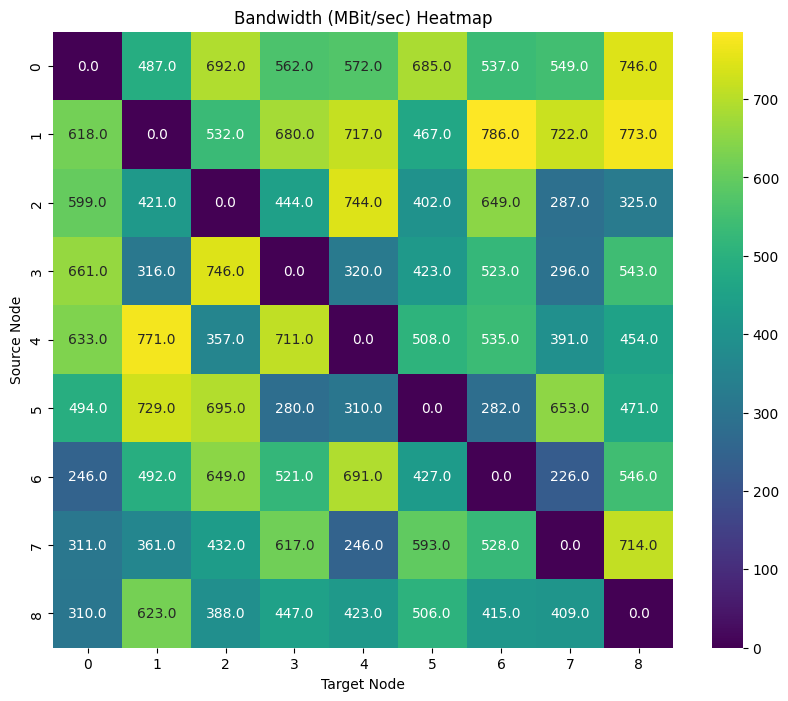

In [3]:

# plot the delay matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the delay matrix from the CSV file
delay_matrix = pd.read_csv('bandwidth_matrix.csv', header=None)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(delay_matrix, annot=True, fmt=".1f", cmap="viridis", cbar=True)
plt.title('Bandwidth (MBit/sec) Heatmap')
plt.xlabel('Target Node')
plt.ylabel('Source Node')
plt.show()

In [3]:
import random
import csv

# Function to generate a bandwidth matrix for a given number of nodes
def generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=600):
    # Create a matrix with zeros or very high values on the diagonal
    bandwidth_matrix = [[0 if i == j else random.randint(min_bandwidth, max_bandwidth)
                         for j in range(num_nodes)] for i in range(num_nodes)]
    return bandwidth_matrix

# Generate bandwidth matrix for 9 nodes
num_nodes = 9
bandwidth_matrix = generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=800)  # Bandwidth in Mbps

# Save the bandwidth matrix to a CSV file
with open('bandwidth_matrix.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(bandwidth_matrix)

# Print matrix to verify
for row in bandwidth_matrix:
    print(row)


[0, 283, 353, 716, 241, 293, 478, 333, 464]
[496, 0, 362, 503, 784, 636, 790, 302, 359]
[259, 460, 0, 592, 327, 796, 697, 618, 339]
[298, 222, 796, 0, 341, 445, 451, 768, 481]
[334, 378, 726, 436, 0, 247, 480, 258, 239]
[387, 543, 606, 763, 660, 0, 747, 665, 604]
[648, 784, 313, 664, 663, 581, 0, 776, 437]
[299, 797, 515, 279, 775, 403, 514, 0, 729]
[425, 248, 692, 792, 216, 544, 319, 727, 0]


In [ ]:
# '''the code is executed in paralla '''

# import random
# import csv
# import paramiko
# from multiprocessing import Pool

# # Function to generate a realistic delay matrix
# def generate_delay_matrix(num_nodes, base_latency=5, max_additional_latency=50):
#     delay_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

#     for i in range(num_nodes):
#         for j in range(num_nodes):
#             if i == j:
#                 delay_matrix[i][j] = 0 # node-to-node its self, latency set to zero
#             else:
#                 # additional_latency = random.uniform(0, max_additional_latency)
#                 additional_latency = random.uniform(0, max_additional_latency)
#                 distance_factor = abs(i - j) / num_nodes
#                 simulated_latency = base_latency + additional_latency * distance_factor
#                 congestion_factor = random.uniform(0.5, 1.5)
#                 delay_matrix[i][j] = int(simulated_latency * congestion_factor) # change the float to integer
#     return delay_matrix

# # Generate delay matrix for 9 worker nodes
# '''Injecting no latencies'''
# # delay_matrix = generate_delay_matrix(num_nodes=9, base_latency=0, max_additional_latency=0)

# # Generate delay matrix for 9 worker nodes
# delay_matrix = generate_delay_matrix(num_nodes=9, base_latency= 5, max_additional_latency= 50)


# # Save the delay matrix to a CSV file
# with open('delay_matrix_parallel.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(delay_matrix)

In [13]:

'''the code is executed in paralla '''
import random
import csv
import paramiko
from multiprocessing import Pool

def apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details):
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()

    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)

        # Clear existing rules and set root qdisc
        client.exec_command(f"sudo tc qdisc del dev {interface} root")
        client.exec_command(f"sudo tc qdisc add dev {interface} root handle 1: htb default 1")
        
        print(f'000Bandwidth cleared for {source_node_name}')

        for dst_node, details in node_details.items():
            if dst_node == source_node_name:
                continue

            dst_node_ip = details['ip']
            bandwidth = bandwidth_matrix[source_node_name][dst_node]
            print(f'111Bandwidth between {source_node_name} and {dst_node}: {bandwidth}')
            client.exec_command(f"sudo tc class add dev {interface} parent 1: classid 1:1 htb rate {bandwidth}mbit") # mbit = 1024 kbit => kilo bit/s
            print(f'222Bandwidth set between {source_node_name} and {dst_node}: {bandwidth}')
            
            client.exec_command(f"sudo tc filter add dev {interface} protocol ip parent 1:0 prio 1 u32 match ip dst {dst_node_ip} flowid 1:1")

            print(f'Bandwidth set between {source_node_name} and {dst_node}: {bandwidth}')

    except Exception as e:
        print(f"Failed to set bandwidth for {source_node_name}: {e}")
    finally:
        client.close()



def exclude_src_node(src_node_name, node_details):
    return {name: details for name, details in node_details.items() if name != src_node_name}

def automate_bandwidth_injection(params):
    source_node_name, bandwidth_matrix, node_details = params
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details)

# Assuming correct IP addresses and no duplication in node keys
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

# Apply latency injection using the generated delay matrix with multiprocessing
params_list = [(source_node, bandwidth_matrix, node_details) for source_node in node_details.keys()]

if __name__ == '__main__':
    with Pool(processes=len(node_details)) as pool:
        pool.map(automate_bandwidth_injection, params_list)


000Bandwidth cleared for k8s-worker-1000Bandwidth cleared for k8s-worker-4

Failed to set bandwidth for k8s-worker-4: list indices must be integers or slices, not strFailed to set bandwidth for k8s-worker-1: list indices must be integers or slices, not str

000Bandwidth cleared for k8s-worker-3
Failed to set bandwidth for k8s-worker-3: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-5
Failed to set bandwidth for k8s-worker-5: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-7
Failed to set bandwidth for k8s-worker-7: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-2000Bandwidth cleared for k8s-worker-6

Failed to set bandwidth for k8s-worker-2: list indices must be integers or slices, not strFailed to set bandwidth for k8s-worker-6: list indices must be integers or slices, not str

000Bandwidth cleared for k8s-worker-9
Failed to set bandwidth for k8s-worker-9: list indices must

In [12]:


# plot the delay matrix
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Read the delay matrix from the CSV file
# delay_matrix = pd.read_csv('delay_matrix_parallel.csv', header=None)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(delay_matrix, annot=True, fmt=".1f", cmap="viridis", cbar=True)
# plt.title('Latency Heatmap')
# plt.xlabel('Target Node')
# plt.ylabel('Source Node')
# plt.show()


000Bandwidth cleared for k8s-worker-4
Failed to set bandwidth for k8s-worker-4: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-1
Failed to set bandwidth for k8s-worker-1: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-6
Failed to set bandwidth for k8s-worker-6: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-2000Bandwidth cleared for k8s-worker-5

Failed to set bandwidth for k8s-worker-2: list indices must be integers or slices, not strFailed to set bandwidth for k8s-worker-5: list indices must be integers or slices, not str

000Bandwidth cleared for k8s-worker-7
Failed to set bandwidth for k8s-worker-7: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-3
Failed to set bandwidth for k8s-worker-3: list indices must be integers or slices, not str
000Bandwidth cleared for k8s-worker-9
Failed to set bandwidth for k8s-worker-9: list indices must